## <b>Homework 6</b>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

### <b>Dataset</b>

In [2]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
df = pd.read_csv(data)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### <b>Preparing the dataset</b>

In [3]:
df = df[
    (df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')
]
df = df.reset_index(drop=True)

In [4]:
df = df.fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [5]:
df.median_house_value = np.log1p(df.median_house_value)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [8]:
dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

### <b>Question 1</b>

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [10]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [11]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



### <b>Question 2</b>

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [13]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)

0.245

### <b>Question 3</b>

In [14]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)
    
    scores.append((n, rmse))

In [15]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

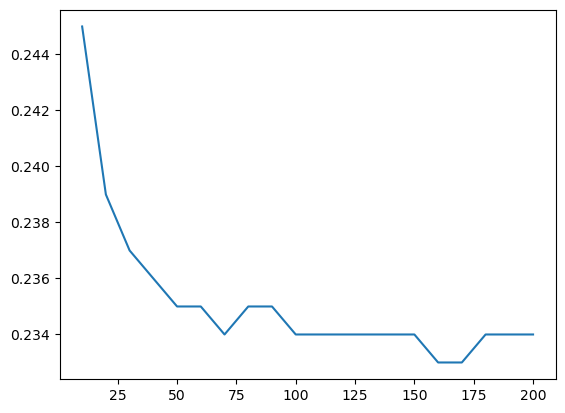

In [16]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

### <b>Question 4</b>

In [17]:
depths = [10, 15, 20, 25]
scores = []

for depth in depths: 
    for n in range(10, 201, 10):
        rmse = []
        
        rf = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse.append(np.sqrt(mean_squared_error(y_val, y_pred)))

    scores.append((depth, np.mean(rmse)))

In [18]:
columns = ['max_depth', 'mean_rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [19]:
df_scores

,max_depth,mean_rmse
0,10,0.244773
1,15,0.234596
2,20,0.233925
3,25,0.233740


### <b>Question 5</b>

In [20]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

df_scores = pd.DataFrame(list(rf.feature_importances_), list(df.columns))
df_scores

,0
longitude,0.015136
latitude,0.030317
housing_median_age,0.102007
total_rooms,0.086244
total_bedrooms,0.335611
population,0.292473
households,0.073806
median_income,0.027136
median_house_value,0.015852
ocean_proximity,0.021417


### <b>Question 6</b>

In [21]:
import xgboost as xgb

In [22]:
features = dv.get_feature_names_out()
features = [f.replace('=<', '_').replace('=', '_') for f in features]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [23]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [24]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=10,
                  evals=watchlist)

In [25]:
s = output.stdout
print(s)

[0]	train-rmse:8.07362	val-rmse:8.07348
[10]	train-rmse:0.33195	val-rmse:0.34802
[20]	train-rmse:0.20036	val-rmse:0.24508
[30]	train-rmse:0.18204	val-rmse:0.23833
[40]	train-rmse:0.16422	val-rmse:0.23379
[50]	train-rmse:0.15210	val-rmse:0.23262
[60]	train-rmse:0.14218	val-rmse:0.23160
[70]	train-rmse:0.13471	val-rmse:0.23108
[80]	train-rmse:0.12835	val-rmse:0.23045
[90]	train-rmse:0.12174	val-rmse:0.22957
[99]	train-rmse:0.11656	val-rmse:0.22897



In [26]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=10,
                  evals=watchlist)

In [27]:
s = output.stdout
print(s)

[0]	train-rmse:10.37456	val-rmse:10.37545
[10]	train-rmse:3.63299	val-rmse:3.62939
[20]	train-rmse:1.29412	val-rmse:1.29329
[30]	train-rmse:0.50217	val-rmse:0.51149
[40]	train-rmse:0.26743	val-rmse:0.29345
[50]	train-rmse:0.21112	val-rmse:0.24907
[60]	train-rmse:0.19724	val-rmse:0.24107
[70]	train-rmse:0.18911	val-rmse:0.23824
[80]	train-rmse:0.18145	val-rmse:0.23594
[90]	train-rmse:0.17418	val-rmse:0.23307
[99]	train-rmse:0.17000	val-rmse:0.23234

